# **Spam Classification example**

In [ ]:
!wget --no-check-certificate https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
!unzip /content/smsspamcollection.zip

--2023-10-15 04:58:04--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘smsspamcollection.zip’

smsspamcollection.z     [ <=>                ] 198.65K  --.-KB/s    in 0.1s    

2023-10-15 04:58:04 (1.84 MB/s) - ‘smsspamcollection.zip’ saved [203415]

Archive:  /content/smsspamcollection.zip
  inflating: SMSSpamCollection       
  inflating: readme                  


In [ ]:
import pandas as pd
import nltk
from sklearn.metrics import accuracy_score, precision_recall_curve, auc

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import matplotlib.pyplot as plt

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
stemmer = PorterStemmer()

def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())

    # Apply stemming to tokens
    stemmed_tokens = [stemmer.stem(token) for token in tokens]

    # Create bigrams from tokens
    bigrams = list(ngrams(stemmed_tokens, 2))
    bigrams = ["_".join(b) for b in bigrams]

    tokens_bigrams = stemmed_tokens # + bigrams
    # Combine tokens and bigrams
    processed_text = ' '.join(tokens_bigrams)

    return processed_text

spam_df = pd.read_csv("/content/SMSSpamCollection", sep='\t', header=None, names=['label', 'message'])
spam_df['processed_text'] = spam_df['message'].apply(preprocess_text)
spam_df['label'] = spam_df['label'] == 'spam'

In [ ]:
spam_df.head()

,label,message,processed_text
0,False,"Go until jurong point, crazy.. Available only ...","go until jurong point , crazi .. avail onli in..."
1,False,Ok lar... Joking wif u oni...,ok lar ... joke wif u oni ...
2,True,Free entry in 2 a wkly comp to win FA Cup fina...,free entri in 2 a wkli comp to win fa cup fina...
3,False,U dun say so early hor... U c already then say...,u dun say so earli hor ... u c alreadi then sa...
4,False,"Nah I don't think he goes to usf, he lives aro...","nah i do n't think he goe to usf , he live aro..."


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(spam_df[['message', 'processed_text']], spam_df['label'], test_size=0.2, random_state=42)

In [ ]:
X_train.head()

,message,processed_text
1978,Reply to win £100 weekly! Where will the 2006 ...,repli to win £100 weekli ! where will the 2006...
3989,Hello. Sort of out in town already. That . So ...,hello . sort of out in town alreadi . that . s...
3935,How come guoyang go n tell her? Then u told her?,how come guoyang go n tell her ? then u told h...
4078,Hey sathya till now we dint meet not even a si...,hey sathya till now we dint meet not even a si...
4086,Orange brings you ringtones from all time Char...,orang bring you rington from all time chart he...


In [ ]:
vectorizer = CountVectorizer(max_features=200)
X_train_vectorized = vectorizer.fit_transform(X_train['processed_text'])


In [ ]:
X_train_vectorized.shape

(4457, 200)

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train_vectorized, y_train)

# Step 3: Evaluate performance on train and test set
X_test_vectorized = vectorizer.transform(X_test['processed_text'])


In [ ]:
X_train_vectorized.shape

(4457, 200)

In [ ]:
train_predictions = logreg.predict(X_train_vectorized)
test_predictions = logreg.predict(X_test_vectorized)

train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

precision, recall, thresholds = precision_recall_curve(y_test, test_predictions)

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")



Train Accuracy: 0.9831725375813327
Test Accuracy: 0.9775784753363229


In [ ]:
import matplotlib.pyplot as plt

def plot_pr_curve(recall, precision):
  average_precision = auc(recall, precision)

  plt.figure(figsize=(3, 3))
  plt.step(recall, precision, color='b', alpha=0.2, where='post')
  plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.ylim([0.0, 1.05])
  plt.xlim([0.0, 1.0])
  plt.title('Precision-Recall Curve (AP={0:0.2f})'.format(average_precision))
  plt.show()


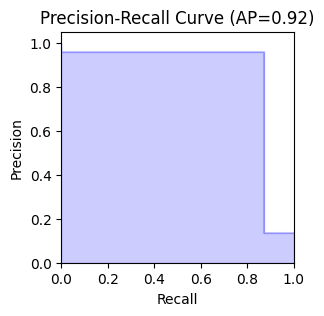

In [ ]:
plot_pr_curve(recall, precision)

### BERT classification

In [ ]:
!pip install transformers

In [ ]:
import tensorflow as tf

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained("google/bert_uncased_L-2_H-128_A-2")
encoded_data = tokenizer(X_train['message'].tolist(), truncation=True, padding=True, return_tensors="tf")

# Create a TensorFlow Dataset
dataset = tf.data.Dataset.from_tensor_slices((dict(encoded_data), y_train.astype(int).tolist()))

model = TFBertForSequenceClassification.from_pretrained("google/bert_uncased_L-2_H-128_A-2", num_labels=2)

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

train_size = int(0.8 * len(X_train))
train_dataset = dataset.take(train_size)
validation_dataset = dataset.skip(train_size)

model.fit(
    train_dataset.shuffle(100).batch(32),
    validation_data=validation_dataset.batch(32),
    epochs=3,
)





Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
112/112 [==============================] - 42s 179ms/step - loss: 0.4323 - accuracy: 0.8965 - val_loss: 0.2561 - val_accuracy: 0.9709
Epoch 2/3
112/112 [==============================] - 14s 125ms/step - loss: 0.1871 - accuracy: 0.9795 - val_loss: 0.1392 - val_accuracy: 0.9809
Epoch 3/3
112/112 [==============================] - 12s 109ms/step - loss: 0.1076 - accuracy: 0.9863 - val_loss: 0.1000 - val_accuracy: 0.9832


In [ ]:
encoded_test_data = tokenizer(X_test['message'].tolist(), truncation=True, padding=True, return_tensors="tf")
test_dataset = tf.data.Dataset.from_tensor_slices((dict(encoded_test_data), y_test.astype(int).tolist()))

test_dataset = test_dataset.batch(32)
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"Test accuracy: {test_accuracy}")


35/35 [==============================] - 2s 17ms/step - loss: 0.0830 - accuracy: 0.9865
Test accuracy: 0.9865471124649048


In [ ]:
y_pred_te = model.predict(test_dataset).logits[:, 1]
y_pred_tr = model.predict(dataset.batch(32)).logits[:, 1]

train_accuracy = accuracy_score(y_train, y_pred_tr > 0)
test_accuracy = accuracy_score(y_test, y_pred_te > 0)
print(train_accuracy, test_accuracy)

140/140 [==============================] - 2s 12ms/step
0.9887816917208885 0.9865470852017937


In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_te)


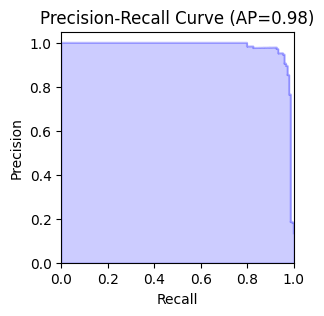

In [ ]:
plot_pr_curve(recall, precision)

# Poisson and Hawkes process

In [ ]:
!pip install tick

In [ ]:
from tick.hawkes import SimuPoissonProcess
from tick.plot import plot_point_process

run_time = 10
intensity = 10 #5, 10
poi = SimuPoissonProcess(intensity, end_time=run_time, verbose=False)
poi.simulate()
plot_point_process(poi)

In [ ]:
import numpy as np
from tick.base import TimeFunction

from tick.plot import plot_point_process
from tick.hawkes import SimuInhomogeneousPoisson

run_time = 30

T = np.linspace(0, run_time, 100)
Y = np.maximum(15 * np.sin(T), 0.001)

tf = TimeFunction((T, Y), dt=0.01)

in_poi = SimuInhomogeneousPoisson([tf], end_time=run_time, verbose=False)

in_poi.track_intensity(0.1)
in_poi.simulate()

plot_point_process(in_poi)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from tick.hawkes import SimuHawkesExpKernels
from tick.plot import plot_point_process

n_nodes = 3  # dimension of the Hawkes process
#adjacency = 0.2 * np.ones((n_nodes, n_nodes))
#adjacency[0, 1] = 0

adjacency = np.zeros((n_nodes, n_nodes))
adjacency[0, 0] = 0
adjacency[1, 0] = 0
adjacency[2, 0] = 0

adjacency[0, 1] = 2
adjacency[1, 1] = 0.3
adjacency[2, 1] = 0.2

adjacency[0, 2] = 5 #share -> views
adjacency[1, 2] = 2 #share -> likes
adjacency[2, 2] = 0.3 #share -> shares

decays = 1 * np.ones((n_nodes, n_nodes))
baseline = 0.2 * np.ones(n_nodes)
hawkes = SimuHawkesExpKernels(adjacency=adjacency, decays=decays, baseline=baseline, verbose=False, seed=0)

run_time = 200
hawkes.end_time = run_time
dt = 0.01
hawkes.track_intensity(dt)
hawkes.simulate()

fig, ax = plt.subplots(n_nodes, 1, figsize=(16, 8), sharex=True, sharey=True)
plot_point_process(hawkes, n_points=50000, t_min=10, max_jumps=30, ax=ax)
#fig.tight_layout()

In [ ]:
from tick.plot import plot_hawkes_kernels
from tick.hawkes import HawkesExpKern

learner = HawkesExpKern(decays, penalty='elasticnet',
                           elastic_net_ratio=0.8)
learner.fit(hawkes.timestamps)

print("Learnt adjacency\n", learner.adjacency)

print("\nTrue adjacency\n", adjacency)